# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
data_train_raw = data_train_raw.sample(frac=0.0001, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(19, 132)

# Data transformation

In [4]:
ylog=np.log1p(data_train_raw['loss'])
ymean=ylog.mean()
ystd=ylog.std()
# ymean=0
# ystd=1
data_train_raw['loss_g']=(ylog-ymean)/ystd

In [5]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: -4.09029535388e-16
Std of log1py: 1.0
Lower clipping bound: -3.0
Upper clipping bound: 3.0
Shape of cleaned data: (19, 133)


In [6]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

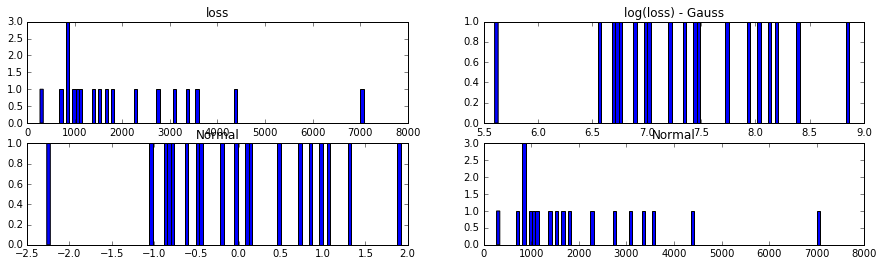

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [8]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [9]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(125565, 130)
(125565, 116) of which are categorical
(125565, 14) of which are continuous


In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


d:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cat107', u'cat108', u'cat109', u'cat110', u'cat111', u'cat112',
       u'cat113', u'cat114', u'cat115', u'cat116'],
      dtype='object', length=116)


# restore to x_trainDf and x_testDf - skipped

In [11]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [12]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding

In [13]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(125565, 1102)


In [14]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [15]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 1116)
(19, 1116)
(19L,)


# splite the training data for valication

In [16]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(15, 1116)
(15L,)
(4, 1116)
(4L,)


d:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
del trainDf
del testDf

# Model Fitting

In [18]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')
testList = ['Ridge', 'LassoLars','RandomForest','ExtraTrees', 'XGBoostTrees','Ensemble']

- Ridge Regression

In [19]:
from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import Ridge

In [20]:
cv = 5
alphas = (1e-2,1e-1,1,1e1,1e2)
regCV = RidgeCV(cv=cv,alphas = alphas)
regCV.fit(x_train,y_train)
print('alpha: {}\n'.format(regCV.alpha_))
# print('cv_values_: {}\n'.format(regCV.cv_values_))

alpha: 10.0



In [21]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

436.025534701


In [22]:
y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

In [23]:
# alpha = 10
# reg = Ridge(alpha=alpha)
# reg.fit(x_train,y_train)
# print('Params: {}\n'.format(reg.get_params))

In [24]:
# validate the model
# 1258.88728608 with alpha = 1
# 1255.3 with alpha = 10
# 1229.3 clip 3*std with alpha = 10
# 1089.81 clip 2*std with alpha = 10 - but the results on the leadre board was not improved
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(reg.predict(x_val),ymean,ystd)))

In [25]:
# y_pred_i = lossRestore(reg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)

- Lars Lasso Regression

In [26]:
from sklearn.linear_model import LassoCV

In [27]:
cv = 5
alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
LassoCV = LassoCV(cv=cv,alphas = alphas)
LassoCV.fit(x_train,y_train)
print('alpha: {}\n'.format(LassoCV.alpha_))

alpha: 0.1



In [28]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

621.758448141


In [29]:
y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

- Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
criterion = 'mae'
n_estimators = (10, 30, 50, 70, 90, 110)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
    tmpRFReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        RFReg = tmpRFReg
        n_estimator = n_est
        err = err_i

665.093439743
629.248231513
652.595300116
664.303793477
635.851641645
645.120720079


In [32]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

n_estimator = 30
629.248231513


In [33]:
y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

- Extra Trees

In [34]:
from sklearn.ensemble import ExtraTreesRegressor

In [35]:
criterion = 'mae'
n_estimators = (10, 50, 70, 90, 110, 130)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpETReg = ExtraTreesRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
    tmpETReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpETReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        ETReg = tmpETReg
        n_estimator = n_est
        err = err_i

766.839813925
707.970003704
686.065390455
682.244766885
678.734432666
679.829479151


In [36]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(ETReg.predict(x_val),ymean,ystd)))

n_estimator = 110
678.734432666


In [37]:
y_pred_i = lossRestore(ETReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(ETReg.predict(x_val),ymean,ystd))

 - XGBoost Trees

In [38]:
import xgboost as xgb

In [39]:
# x_train, x_val, y_train, y_val
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [40]:
num_round = 30
params = {'eval_metric':'mae'}
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.685591	train-mae:0.729768
[1]	eval-mae:0.569745	train-mae:0.559792
[2]	eval-mae:0.599789	train-mae:0.43301
[3]	eval-mae:0.599789	train-mae:0.34252
[4]	eval-mae:0.599789	train-mae:0.271573
[5]	eval-mae:0.599789	train-mae:0.219024
[6]	eval-mae:0.599789	train-mae:0.177696
[7]	eval-mae:0.584602	train-mae:0.144024
[8]	eval-mae:0.584602	train-mae:0.118174
[9]	eval-mae:0.584602	train-mae:0.097128
[10]	eval-mae:0.584602	train-mae:0.079745
[11]	eval-mae:0.584602	train-mae:0.065837
[12]	eval-mae:0.584602	train-mae:0.054449
[13]	eval-mae:0.582464	train-mae:0.045024
[14]	eval-mae:0.582464	train-mae:0.037478
[15]	eval-mae:0.581917	train-mae:0.031225
[16]	eval-mae:0.581479	train-mae:0.026152
[17]	eval-mae:0.581127	train-mae:0.021974
[18]	eval-mae:0.581127	train-mae:0.018482
[19]	eval-mae:0.580934	train-mae:0.01554
[20]	eval-mae:0.580934	train-mae:0.013106
[21]	eval-mae:0.580934	train-mae:0.011077
[22]	eval-mae:0.581048	train-mae:0.009363
[23]	eval-mae:0.58114	train-mae:0.007935
[24]	e

In [41]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

706.660020752


In [42]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

# save files for submission

In [43]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


583.71116442812206

In [44]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)